In [1]:
import json
import pandas as pd
from pathlib import Path
from pprint import pprint
import datetime
import time
import numpy as np
import matplotlib as plt

import pandas
import researchpy as rp
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

%matplotlib inline

In [2]:
#path_results = Path('/media/discoD/models/elmo/ner/datalawyer')
path_results = Path('/opt/models/elmo/ner/results_datalawyer_jur_embeddings_com_lower_ner_com_lower/')
#path_results = Path('/opt/models/elmo/ner/results_datalawyer_jur/')

In [3]:
for folder in path_results.iterdir():
    print(folder)

/opt/models/elmo/ner/results_datalawyer_jur_embeddings_com_lower_ner_com_lower/datalawyer
/opt/models/elmo/ner/results_datalawyer_jur_embeddings_com_lower_ner_com_lower/datalawyer-ft


In [4]:
configs = dict()
metrics = dict()
for folder in path_results.iterdir():
    if folder.is_dir():
        results_model_folder = folder.iterdir()
        for training_folder in results_model_folder:
            #print('Reading files from %s' % training_folder.name)
            has_metrics = False
            for results_file in training_folder.iterdir():
                if results_file.name.endswith('.json'):
                    #print('Parsing data from %s' % results_file.name)
                    if results_file.name.startswith('config'):
                        configs[training_folder.name] = json.loads(results_file.read_bytes())
                    elif results_file.name.startswith('metrics.'):
                        metrics[training_folder.name] = json.loads(results_file.read_bytes())
                        has_metrics = True
            if not has_metrics:
                print('metrics.json not found for %s' % training_folder.name)
                del configs[training_folder.name]
print(len(metrics))
print(len(configs))

metrics.json not found for datalawyer-ft_word2vec_cbow_0_1
45
45


In [5]:
def get_seconds(time_str):
    x = time.strptime(time_str,'%H:%M:%S')
    return datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()
def get_average_epoch_duration(metrics):
    seconds = get_seconds(metrics['training_duration'])
    training_epochs = metrics['training_epochs'] + 1
    return seconds / training_epochs

In [6]:
TRAINING_ID = 'Training_ID'
SCENARIO = 'Scenario'
MODEL = 'Model'
EMBEDDING = 'Embedding'
EMBEDDING_TYPE = 'Embedding_Type'
DOMAN_SPECIFIC = 'Domain_Specific'
BATCH_SIZE = 'Batch_Size'
ELMO_DROPOUT = 'ELMo_Dropout'
TRAINING_NUMBER = 'Training_Number'
EXECUTION_NUMBER = 'Execution_Number'
BEST_EPOCH = 'Best_Epoch'
TRAINING_EPOCHS = 'Training_Epochs'
TRAINING_DURATION = 'Training_Duration'
TOTAL_DURATION = 'Total_Duration(s)'
AVERAGE_EPOCH_DURATION = 'Average_Epoch_Duration(s)'
TRAINING_ACCURACY = 'Training_Accuracy'
TRAINING_ACCURACY_TOP3 = 'Training_Accuracy_Top-3'
TRAINING_PRECISION = 'Training_Precision'
TRAINING_RECALL = 'Training_Recall'
TRAINING_F1_MEASURE = 'Training_F1-Measure'
TRAINING_LOSS = 'Training_Loss'
BEST_VALIDATION_ACCURACY = 'Best_Validation_Accuracy'
BEST_VALIDATION_ACCURACY_TOP3 = 'Best_Validation_Accuracy_Top-3'
BEST_VALIDATION_PRECISION = 'Best_Validation_Precision'
BEST_VALIDATION_RECALL = 'Best_Validation_Recall'
BEST_VALIDATION_F1_MEASURE = 'Best_Validation_F1-Measure'
BEST_VALIDATION_LOSS = 'Best_Validation_Loss'
TEST_ACCURACY = 'Test_Accuracy'
TEST_ACCURACY_TOP3 = 'Test_Accuracy_Top-3'
TEST_PRECISION = 'Test_Precision'
TEST_RECALL = 'Test_Recall'
TEST_F1_MEASURE = 'Test_F1_Measure'
TEST_LOSS = 'Test_Loss'
columns = [TRAINING_ID, MODEL, EMBEDDING, DOMAN_SPECIFIC, EMBEDDING_TYPE, TRAINING_NUMBER, EXECUTION_NUMBER, BEST_EPOCH, TRAINING_EPOCHS, TRAINING_DURATION, TOTAL_DURATION, AVERAGE_EPOCH_DURATION, TRAINING_ACCURACY, TRAINING_ACCURACY_TOP3, TRAINING_PRECISION, TRAINING_RECALL, TRAINING_F1_MEASURE, TRAINING_LOSS, BEST_VALIDATION_ACCURACY, BEST_VALIDATION_ACCURACY_TOP3, BEST_VALIDATION_PRECISION, BEST_VALIDATION_RECALL, BEST_VALIDATION_F1_MEASURE, BEST_VALIDATION_LOSS, TEST_ACCURACY, TEST_ACCURACY_TOP3, TEST_PRECISION, TEST_RECALL, TEST_F1_MEASURE, TEST_LOSS]
columns

['Training_ID',
 'Model',
 'Embedding',
 'Domain_Specific',
 'Embedding_Type',
 'Training_Number',
 'Execution_Number',
 'Best_Epoch',
 'Training_Epochs',
 'Training_Duration',
 'Total_Duration(s)',
 'Average_Epoch_Duration(s)',
 'Training_Accuracy',
 'Training_Accuracy_Top-3',
 'Training_Precision',
 'Training_Recall',
 'Training_F1-Measure',
 'Training_Loss',
 'Best_Validation_Accuracy',
 'Best_Validation_Accuracy_Top-3',
 'Best_Validation_Precision',
 'Best_Validation_Recall',
 'Best_Validation_F1-Measure',
 'Best_Validation_Loss',
 'Test_Accuracy',
 'Test_Accuracy_Top-3',
 'Test_Precision',
 'Test_Recall',
 'Test_F1_Measure',
 'Test_Loss']

In [7]:
def get_training_data_from_id(training_id, config):
    data = training_id.split('_')
    print(data)
    if len(data) == 4:
        return {MODEL: data[0], EMBEDDING: data[1], DOMAN_SPECIFIC: False, EMBEDDING_TYPE: 'No', TRAINING_NUMBER: data[2], EXECUTION_NUMBER: data[3]}
    elif len(data) == 5:
        embedding_type = 'No' if data[1] == 'glove-lc' else data[2]
        domain_specific = data[2] == 'jur'
        return {MODEL: data[0], EMBEDDING: data[1], DOMAN_SPECIFIC: domain_specific, EMBEDDING_TYPE: embedding_type, TRAINING_NUMBER: data[3], EXECUTION_NUMBER: data[4]}
    elif len(data) == 6:
        embedding_type = 'No' if data[1] == 'glove-lc' else data[3]
        domain_specific = data[2] == 'jur'
        embedding = data[1] + '-' + data[3] if data[1] == 'glove-lc' else data[1]
        return {MODEL: data[0], EMBEDDING: embedding, DOMAN_SPECIFIC: domain_specific, EMBEDDING_TYPE: embedding_type, TRAINING_NUMBER: data[4], EXECUTION_NUMBER: data[5]}
    elif len(data) == 7:
        return {MODEL: data[0], EMBEDDING: data[1] + '-' + data[4], DOMAN_SPECIFIC: True, EMBEDDING_TYPE: data[3], TRAINING_NUMBER: data[5], EXECUTION_NUMBER: data[6]}
    else:
        print('Invalid id: %s' % training_id)

In [8]:
training_data = []
for training_id, config in configs.items():
    training_metrics = metrics[training_id]
    data = get_training_data_from_id(training_id, config)
    data[TRAINING_ID] = training_id
    data[BEST_EPOCH] = training_metrics['best_epoch'] if training_metrics else None
    data[TRAINING_EPOCHS] = training_metrics['training_epochs'] + 1 if training_metrics else None
    data[TRAINING_DURATION] = training_metrics['training_duration'] if training_metrics else None
    data[TOTAL_DURATION] = get_seconds(training_metrics['training_duration']) if training_metrics else None
    data[AVERAGE_EPOCH_DURATION] = get_average_epoch_duration(training_metrics) if training_metrics else None
    data[TRAINING_ACCURACY] = training_metrics['training_accuracy'] if training_metrics else None
    data[TRAINING_ACCURACY_TOP3] = training_metrics['training_accuracy3'] if training_metrics else None
    data[TRAINING_PRECISION] = training_metrics['training_precision-overall'] if training_metrics else None
    data[TRAINING_RECALL] = training_metrics['training_recall-overall'] if training_metrics else None
    data[TRAINING_F1_MEASURE] = training_metrics['training_f1-measure-overall'] if training_metrics else None
    data[TRAINING_LOSS] = training_metrics['training_loss'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY] = training_metrics['best_validation_accuracy'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY_TOP3] = training_metrics['best_validation_accuracy3'] if training_metrics else None
    data[BEST_VALIDATION_PRECISION] = training_metrics['best_validation_precision-overall'] if training_metrics else None
    data[BEST_VALIDATION_RECALL] = training_metrics['best_validation_recall-overall'] if training_metrics else None
    data[BEST_VALIDATION_F1_MEASURE] = training_metrics['best_validation_f1-measure-overall'] if training_metrics else None
    data[BEST_VALIDATION_LOSS] = training_metrics['best_validation_loss'] if training_metrics else None
    data[TEST_ACCURACY] = training_metrics['test_accuracy'] if training_metrics else None
    data[TEST_ACCURACY_TOP3] = training_metrics['test_accuracy3'] if training_metrics else None
    data[TEST_PRECISION] = training_metrics['test_precision-overall'] if training_metrics else None
    data[TEST_RECALL] = training_metrics['test_recall-overall'] if training_metrics else None
    data[TEST_F1_MEASURE] = training_metrics['test_f1-measure-overall'] if training_metrics else None
    data[TEST_LOSS] = training_metrics['test_loss'] if training_metrics else None
    training_data.append(data)

['datalawyer', 'glove-lc', 'jur', '5B-mc10', '0', '0']
['datalawyer', 'wang2vec-lc', 'jur', 'cbow', '0', '1']
['datalawyer', 'word2vec-lc', 'jur', 'skip', '0', '2']
['datalawyer', 'fasttext-lc', 'jur', 'cbow', '0', '2']
['datalawyer', 'fasttext-lc', 'jur', 'skip', '0', '0']
['datalawyer', 'glove-lc', 'jur', '0', '2']
['datalawyer', 'glove-lc', 'jur', '5B-mc10', '0', '2']
['datalawyer', 'word2vec-lc', 'jur', 'cbow', '5B-mc10', '0', '0']
['datalawyer', 'word2vec-lc', 'jur', 'cbow', '0', '2']
['datalawyer', 'glove-lc', 'jur', '0', '0']
['datalawyer', 'fasttext-lc', 'jur', 'cbow', '0', '1']
['datalawyer', 'wang2vec-lc', 'jur', 'skip', '0', '2']
['datalawyer', 'word2vec-lc', 'jur', 'skip', '5B', '0', '1']
['datalawyer', 'word2vec-lc', 'jur', 'skip', '0', '0']
['datalawyer', 'glove-lc', 'jur', '0', '1']
['datalawyer', 'glove-lc', 'jur', '5B-mc10', '0', '1']
['datalawyer', 'word2vec-lc', 'jur', 'skip', '5B-mc10', '0', '1']
['datalawyer', 'word2vec-lc', 'jur', 'cbow', '5B-mc10', '0', '2']
['da

In [9]:
pd.set_option('display.max_columns', 1000)
training_data_df = pd.DataFrame(training_data, columns=columns)
training_data_df

,Training_ID,Model,Embedding,Domain_Specific,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
0,datalawyer_glove-lc_jur_5B-mc10_0_0,datalawyer,glove-lc-5B-mc10,True,No,0,0,8,20,01:22:36,4956.0,247.80,0.995693,0.995897,0.950237,0.950857,0.950547,6.893538,0.987811,0.988107,0.879259,0.893825,0.886482,28.959243,0.987238,0.987749,0.852446,0.873824,0.863003,35.517847
1,datalawyer_wang2vec-lc_jur_cbow_0_1,datalawyer,wang2vec-lc,True,cbow,0,1,17,20,01:23:46,5026.0,251.30,0.996273,0.996419,0.958694,0.958694,0.958694,6.068438,0.989088,0.989421,0.889640,0.892319,0.890977,34.276933,0.986024,0.986499,0.844615,0.860502,0.852484,47.152097
2,datalawyer_word2vec-lc_jur_skip_0_2,datalawyer,word2vec-lc,True,skip,0,2,10,20,01:20:09,4809.0,240.45,0.995962,0.996158,0.953390,0.955102,0.954245,6.709667,0.987996,0.988237,0.880673,0.905873,0.893096,28.905171,0.986692,0.987203,0.838734,0.872257,0.855167,40.103092
3,datalawyer_fasttext-lc_jur_cbow_0_2,datalawyer,fasttext-lc,True,cbow,0,2,14,20,01:24:05,5045.0,252.25,0.992004,0.992343,0.915971,0.912980,0.914473,11.454841,0.987904,0.988366,0.885331,0.895331,0.890303,24.425737,0.985988,0.986657,0.854574,0.856583,0.855577,33.129692
4,datalawyer_fasttext-lc_jur_skip_0_0,datalawyer,fasttext-lc,True,skip,0,0,14,20,01:24:08,5048.0,252.40,0.996381,0.996580,0.958449,0.956571,0.957509,5.943433,0.988385,0.988810,0.876479,0.892319,0.884328,30.377940,0.986499,0.987115,0.842146,0.861285,0.851608,42.248518
5,datalawyer_glove-lc_jur_0_2,datalawyer,glove-lc,True,No,0,2,12,20,01:25:22,5122.0,256.10,0.995685,0.995881,0.950745,0.948571,0.949657,6.985660,0.988958,0.989217,0.884615,0.900602,0.892537,29.904584,0.986217,0.986622,0.848669,0.874608,0.861443,41.055470
6,datalawyer_glove-lc_jur_5B-mc10_0_2,datalawyer,glove-lc-5B-mc10,True,No,0,2,17,20,01:25:30,5130.0,256.50,0.995635,0.995827,0.949935,0.951020,0.950477,6.974377,0.987663,0.988033,0.883982,0.889307,0.886637,32.433017,0.985355,0.985936,0.841221,0.863636,0.852282,44.111798
7,datalawyer_word2vec-lc_jur_cbow_5B-mc10_0_0,datalawyer,word2vec-lc-5B-mc10,True,cbow,0,0,14,20,01:25:00,5100.0,255.00,0.993518,0.993829,0.926114,0.922939,0.924524,9.280686,0.988625,0.989106,0.886398,0.893072,0.889722,25.717168,0.986200,0.986780,0.857143,0.869906,0.863477,35.151747
8,datalawyer_word2vec-lc_jur_cbow_0_2,datalawyer,word2vec-lc,True,cbow,0,2,15,20,01:22:27,4947.0,247.35,0.993872,0.994148,0.929085,0.928327,0.928706,9.617297,0.988644,0.989014,0.887061,0.893072,0.890056,27.143066,0.987009,0.987537,0.852134,0.876176,0.863988,37.228111
9,datalawyer_glove-lc_jur_0_0,datalawyer,glove-lc,True,No,0,0,16,20,01:27:38,5258.0,262.90,0.995689,0.995881,0.949183,0.948408,0.948795,7.107949,0.987663,0.988144,0.878229,0.896084,0.887067,32.816166,0.986024,0.986587,0.835596,0.868339,0.851653,44.667346


In [10]:
training_data_df.to_csv('training_data_20_epochs_mestrado_datalawyer.csv', index=None)

In [11]:
str(datetime.timedelta(seconds=training_data_df[TOTAL_DURATION].mean()))

'1:22:51.533333'

In [12]:
training_data_df.groupby([MODEL]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Model,,,,,,,,
datalawyer-ft,9.0,0.862441,0.003831,0.855365,0.860257,0.862853,0.864886,0.867895
datalawyer,36.0,0.857422,0.004541,0.845566,0.853968,0.857474,0.861161,0.863988


In [13]:
training_data_df.groupby([EMBEDDING_TYPE]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding_Type,,,,,,,,
No,8.0,0.859780,0.005149,0.851653,0.857080,0.862148,0.863112,0.864886
cbow,18.0,0.858731,0.004181,0.852194,0.855418,0.859083,0.863259,0.863988
skip,19.0,0.857567,0.005309,0.845566,0.854748,0.857253,0.860662,0.867895


In [14]:
training_data_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
glove,1.0,0.864886,NaN,0.864886,0.864886,0.864886,0.864886,0.864886
wang2vec,3.0,0.863221,0.002705,0.860257,0.862053,0.863850,0.864703,0.865556
none,1.0,0.862853,NaN,0.862853,0.862853,0.862853,0.862853,0.862853
word2vec,2.0,0.861630,0.008860,0.855365,0.858498,0.861630,0.864763,0.867895
fasttext,2.0,0.860654,0.002936,0.858578,0.859616,0.860654,0.861692,0.862730
glove-lc-5B-mc10,3.0,0.859575,0.006320,0.852282,0.857642,0.863003,0.863221,0.863440
word2vec-lc-5B,6.0,0.858986,0.002917,0.855135,0.856994,0.859747,0.859988,0.863142
word2vec-lc-5B-mc10,6.0,0.858722,0.004069,0.854118,0.855409,0.858323,0.862322,0.863477
word2vec-lc,6.0,0.857809,0.004761,0.852194,0.854817,0.856484,0.861703,0.863988


In [15]:
training_data_df.groupby([EMBEDDING, EMBEDDING_TYPE]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

count      mean       std       min  \
Embedding           Embedding_Type                                        
word2vec            skip              1.0  0.867895       NaN  0.867895   
glove               No                1.0  0.864886       NaN  0.864886   
wang2vec            cbow              1.0  0.863850       NaN  0.863850   
                    skip              2.0  0.862906  0.003747  0.860257   
none                No                1.0  0.862853       NaN  0.862853   
fasttext            skip              1.0  0.862730       NaN  0.862730   
word2vec-lc-5B      cbow              3.0  0.860915  0.001940  0.859588   
word2vec-lc-5B-mc10 cbow              3.0  0.860298  0.005353  0.854118   
glove-lc-5B-mc10    No                3.0  0.859575  0.006320  0.852282   
fasttext            cbow              1.0  0.858578       NaN  0.858578   
word2vec-lc         cbow              3.0  0.857994  0.005899  0.852194   
                    skip              3.0  0.857624  0.004665  0.854701   
fasttext-lc         cbow              3.0  0.857484  0.002168  0.855577   
glove-lc            No                3.0  0.857258  0.005048  0.851653   
word2vec-lc-5B-mc10 skip              3.0  0.857147  0.002301  0.854795   
word2vec-lc-5B      skip              3.0  0.857057  0.002518  0.855135   
wang2vec-lc         cbow              3.0  0.856433  0.006000  0.852484   
word2vec            cbow              1.0  0.855365       NaN  0.855365   
fasttext-lc         skip              3.0  0.855024  0.005249  0.851608   
wang2vec-lc         skip              3.0  0.852259  0.006161  0.845566   

                                         25%       50%       75%       max  
Embedding           Embedding_Type                                          
word2vec            skip            0.867895  0.867895  0.867895  0.867895  
glove               No              0.864886  0.864886  0.864886  0.864886  
wang2vec            cbow            0.863850  0.863850  0.863850  0.863850  
                    skip            0.861582  0.862906  0.864231  0.865556  
none                No              0.862853  0.862853  0.862853  0.862853  
fasttext            skip            0.862730  0.862730  0.862730  0.862730  
word2vec-lc-5B      cbow            0.859802  0.860015  0.861578  0.863142  
word2vec-lc-5B-mc10 cbow            0.858708  0.863298  0.863388  0.863477  
glove-lc-5B-mc10    No              0.857642  0.863003  0.863221  0.863440  
fasttext            cbow            0.858578  0.858578  0.858578  0.858578  
word2vec-lc         cbow            0.854998  0.857802  0.860895  0.863988  
                    skip            0.854934  0.855167  0.859085  0.863003  
fasttext-lc         cbow            0.856305  0.857032  0.858437  0.859843  
glove-lc            No              0.855166  0.858679  0.860061  0.861443  
word2vec-lc-5B-mc10 skip            0.856024  0.857253  0.858323  0.859393  
word2vec-lc-5B      skip            0.855632  0.856129  0.858018  0.859907  
wang2vec-lc         cbow            0.852981  0.853478  0.858408  0.863337  
word2vec            cbow            0.855365  0.855365  0.855365  0.855365  
fasttext-lc         skip            0.852002  0.852396  0.856732  0.861068  
wang2vec-lc         skip            0.849542  0.853518  0.855606  0.857694

In [16]:
training_data_df.groupby([EMBEDDING, DOMAN_SPECIFIC]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,,count,mean,std,min,25%,50%,75%,max
Embedding,Domain_Specific,,,,,,,,
glove,False,1.0,0.864886,NaN,0.864886,0.864886,0.864886,0.864886,0.864886
wang2vec,False,3.0,0.863221,0.002705,0.860257,0.862053,0.863850,0.864703,0.865556
none,False,1.0,0.862853,NaN,0.862853,0.862853,0.862853,0.862853,0.862853
word2vec,False,2.0,0.861630,0.008860,0.855365,0.858498,0.861630,0.864763,0.867895
fasttext,False,2.0,0.860654,0.002936,0.858578,0.859616,0.860654,0.861692,0.862730
glove-lc-5B-mc10,True,3.0,0.859575,0.006320,0.852282,0.857642,0.863003,0.863221,0.863440
word2vec-lc-5B,True,6.0,0.858986,0.002917,0.855135,0.856994,0.859747,0.859988,0.863142
word2vec-lc-5B-mc10,True,6.0,0.858722,0.004069,0.854118,0.855409,0.858323,0.862322,0.863477
word2vec-lc,True,6.0,0.857809,0.004761,0.852194,0.854817,0.856484,0.861703,0.863988


In [17]:
training_data_df.groupby([EMBEDDING, EMBEDDING_TYPE, DOMAN_SPECIFIC]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

count      mean       std  \
Embedding           Embedding_Type Domain_Specific                              
word2vec            skip           False              1.0  0.867895       NaN   
glove               No             False              1.0  0.864886       NaN   
wang2vec            cbow           False              1.0  0.863850       NaN   
                    skip           False              2.0  0.862906  0.003747   
none                No             False              1.0  0.862853       NaN   
fasttext            skip           False              1.0  0.862730       NaN   
word2vec-lc-5B      cbow           True               3.0  0.860915  0.001940   
word2vec-lc-5B-mc10 cbow           True               3.0  0.860298  0.005353   
glove-lc-5B-mc10    No             True               3.0  0.859575  0.006320   
fasttext            cbow           False              1.0  0.858578       NaN   
word2vec-lc         cbow           True               3.0  0.857994  0.005899   
                    skip           True               3.0  0.857624  0.004665   
fasttext-lc         cbow           True               3.0  0.857484  0.002168   
glove-lc            No             True               3.0  0.857258  0.005048   
word2vec-lc-5B-mc10 skip           True               3.0  0.857147  0.002301   
word2vec-lc-5B      skip           True               3.0  0.857057  0.002518   
wang2vec-lc         cbow           True               3.0  0.856433  0.006000   
word2vec            cbow           False              1.0  0.855365       NaN   
fasttext-lc         skip           True               3.0  0.855024  0.005249   
wang2vec-lc         skip           True               3.0  0.852259  0.006161   

                                                         min       25%  \
Embedding           Embedding_Type Domain_Specific                       
word2vec            skip           False            0.867895  0.867895   
glove               No             False            0.864886  0.864886   
wang2vec            cbow           False            0.863850  0.863850   
                    skip           False            0.860257  0.861582   
none                No             False            0.862853  0.862853   
fasttext            skip           False            0.862730  0.862730   
word2vec-lc-5B      cbow           True             0.859588  0.859802   
word2vec-lc-5B-mc10 cbow           True             0.854118  0.858708   
glove-lc-5B-mc10    No             True             0.852282  0.857642   
fasttext            cbow           False            0.858578  0.858578   
word2vec-lc         cbow           True             0.852194  0.854998   
                    skip           True             0.854701  0.854934   
fasttext-lc         cbow           True             0.855577  0.856305   
glove-lc            No             True             0.851653  0.855166   
word2vec-lc-5B-mc10 skip           True             0.854795  0.856024   
word2vec-lc-5B      skip           True             0.855135  0.855632   
wang2vec-lc         cbow           True             0.852484  0.852981   
word2vec            cbow           False            0.855365  0.855365   
fasttext-lc         skip           True             0.851608  0.852002   
wang2vec-lc         skip           True             0.845566  0.849542   

                                                         50%       75%  \
Embedding           Embedding_Type Domain_Specific                       
word2vec            skip           False            0.867895  0.867895   
glove               No             False            0.864886  0.864886   
wang2vec            cbow           False            0.863850  0.863850   
                    skip           False            0.862906  0.864231   
none                No             False            0.862853  0.862853   
fasttext            skip           False            0.862730  0.862730   
word2vec-lc-5B      cbow           True         

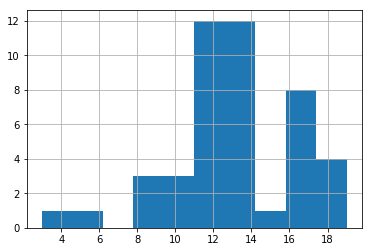

In [18]:
training_data_df[BEST_EPOCH].hist()

In [19]:
training_data_df[TOTAL_DURATION].describe()

count      45.000000
mean     4971.533333
std       131.177465
min      4665.000000
25%      4876.000000
50%      4955.000000
75%      5048.000000
max      5258.000000
Name: Total_Duration(s), dtype: float64

In [20]:
training_data_df.groupby([TRAINING_NUMBER]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Training_Number,,,,,,,,
0,45.0,0.858426,0.004816,0.845566,0.854795,0.858679,0.863003,0.867895


In [21]:
rp.summary_cont(training_data_df[TEST_F1_MEASURE])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Test_F1_Measure,45.0,0.858426,0.004816,0.000718,0.856979,0.859873


In [22]:
rp.summary_cont(training_data_df.groupby(MODEL))[TEST_F1_MEASURE]

,N,Mean,SD,SE,95% Conf.,Interval
Model,,,,,,
datalawyer,36,0.857422,0.004541,0.000757,0.855939,0.858906
datalawyer-ft,9,0.862441,0.003831,0.001277,0.859938,0.864944


In [23]:
rp.summary_cont(training_data_df.groupby(EMBEDDING))[TEST_F1_MEASURE]

/home/user/anaconda3/envs/allennlp/lib/python3.6/site-packages/researchpy/summary.py:151: RuntimeWarning: invalid value encountered in double_scalars
  l_ci = lambda x: numpy.mean(x) - (1.960 * (numpy.std(x)/numpy.sqrt(x.count() - 1)))
/home/user/anaconda3/envs/allennlp/lib/python3.6/site-packages/researchpy/summary.py:154: RuntimeWarning: invalid value encountered in double_scalars
  u_ci = lambda x: numpy.mean(x) + (1.960 * (numpy.std(x)/numpy.sqrt(x.count() - 1)))


,N,Mean,SD,SE,95% Conf.,Interval
Embedding,,,,,,
fasttext,2,0.860654,0.002936,0.002076,0.856585,0.864723
fasttext-lc,6,0.856254,0.003836,0.001566,0.853184,0.859323
glove,1,0.864886,NaN,NaN,NaN,NaN
glove-lc,3,0.857258,0.005048,0.002914,0.851546,0.862970
glove-lc-5B-mc10,3,0.859575,0.006320,0.003649,0.852423,0.866726
none,1,0.862853,NaN,NaN,NaN,NaN
wang2vec,3,0.863221,0.002705,0.001562,0.860160,0.866282
wang2vec-lc,6,0.854346,0.005900,0.002409,0.849625,0.859067
word2vec,2,0.861630,0.008860,0.006265,0.849351,0.873909


In [24]:
rp.summary_cont(training_data_df.groupby([MODEL,EMBEDDING]))[TEST_F1_MEASURE]

N      Mean        SD        SE  95% Conf.  \
Model         Embedding                                                         
datalawyer    fasttext-lc          6  0.856254  0.003836  0.001566   0.853184   
              glove-lc             3  0.857258  0.005048  0.002914   0.851546   
              glove-lc-5B-mc10     3  0.859575  0.006320  0.003649   0.852423   
              wang2vec-lc          6  0.854346  0.005900  0.002409   0.849625   
              word2vec-lc          6  0.857809  0.004761  0.001944   0.854000   
              word2vec-lc-5B       6  0.858986  0.002917  0.001191   0.856652   
              word2vec-lc-5B-mc10  6  0.858722  0.004069  0.001661   0.855466   
datalawyer-ft fasttext             2  0.860654  0.002936  0.002076   0.856585   
              glove                1  0.864886       NaN       NaN        NaN   
              none                 1  0.862853       NaN       NaN        NaN   
              wang2vec             3  0.863221  0.002705  0.001562   0.860160   
              word2vec             2  0.861630  0.008860  0.006265   0.849351   

                                   Interval  
Model         Embedding                      
datalawyer    fasttext-lc          0.859323  
              glove-lc             0.862970  
              glove-lc-5B-mc10     0.866726  
              wang2vec-lc          0.859067  
              word2vec-lc          0.861618  
              word2vec-lc-5B       0.861320  
              word2vec-lc-5B-mc10  0.861978  
datalawyer-ft fasttext             0.864723  
              glove                     NaN  
              none                      NaN  
              wang2vec             0.866282  
              word2vec             0.873909

In [25]:
print(TEST_F1_MEASURE, MODEL, EMBEDDING, BATCH_SIZE, ELMO_DROPOUT)

Test_F1_Measure Model Embedding Batch_Size ELMo_Dropout


In [26]:
# Calculating effect size
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

def print_anova(parameter):
    # Fits the model with the interaction term
    # This will also automatically include the main effects for each factor
    model = ols('Test_F1_Measure ~ C({0})'.format(parameter), training_data_df).fit()
    # Seeing if the overall model is significant
    print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .20f}")
    print(model.summary())
    res = sm.stats.anova_lm(model, typ= 2)
    print(res)
    print(anova_table(res))
    mc = statsmodels.stats.multicomp.MultiComparison(training_data_df[TEST_F1_MEASURE], training_data_df[parameter])
    mc_results = mc.tukeyhsd()
    print(mc_results)

In [27]:
print_anova(EMBEDDING)

Overall model F( 11, 33) =  1.259, p =  0.29012610054162746298
                            OLS Regression Results                            
Dep. Variable:        Test_F1_Measure   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     1.259
Date:                Tue, 28 May 2019   Prob (F-statistic):              0.290
Time:                        06:35:03   Log-Likelihood:                 184.65
No. Observations:                  45   AIC:                            -345.3
Df Residuals:                      33   BIC:                            -323.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------